# Changing division of wines into quality label 
## High is 7,8,9

In [2]:
''' statements to import libraries'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
from scipy.stats import kurtosis
from pandas.api.types import CategoricalDtype
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import cohen_kappa_score
from sklearn.neighbors import KNeighborsClassifier

pd.set_option('display.width', 1000)  # Set the maximum width of the display
pd.set_option('display.max_columns', None)  # Display all columns without truncation
np.set_printoptions(linewidth=150)





In [3]:
'''statements to add csv files, remove duplicates etc. Just Red and white individually
'''
#White wine
white_df = pd.read_csv('wine+quality/winequality-white.csv', sep= ';')
white_copy = white_df.copy()
white_copy.columns = white_copy.columns.str.replace(' ', '_')
print(white_copy.head())

white_copy = white_copy.drop_duplicates()
print(white_copy.head())

if 'colour' not in white_copy.columns:
    white_copy['colour'] = 'white'
else:
    pass

#Red wine
red_df = pd.read_csv('wine+quality/winequality-red.csv', sep = ';')
red_copy = red_df.copy()
if 'colour' not in red_copy.columns:
    red_copy['colour'] = 'red'
else:
    pass

red_copy.columns = red_copy.columns.str.replace(' ', '_')
red_copy = red_copy.drop_duplicates()


   fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  alcohol  quality
0            7.0              0.27         0.36            20.7      0.045                 45.0                 170.0   1.0010  3.00       0.45      8.8        6
1            6.3              0.30         0.34             1.6      0.049                 14.0                 132.0   0.9940  3.30       0.49      9.5        6
2            8.1              0.28         0.40             6.9      0.050                 30.0                  97.0   0.9951  3.26       0.44     10.1        6
3            7.2              0.23         0.32             8.5      0.058                 47.0                 186.0   0.9956  3.19       0.40      9.9        6
4            7.2              0.23         0.32             8.5      0.058                 47.0                 186.0   0.9956  3.19       0.40      9.9        6
   fixed_acidity  volatile_a

In [4]:
''' add new column to wine_quality
low <= 5
5 < medium < 7
high >= 7
'''
if 'quality_label' not in white_copy.columns:
    white_copy['quality_label'] = white_copy.quality.apply(lambda value: 'low' if value <= 5 else 'medium' if value < 7 else 'high')
else:
    pass


if 'quality_label' not in red_copy.columns:
    red_copy['quality_label'] = red_copy.quality.apply(lambda value: 'low' if value <= 5 else 'medium' if value < 7 else 'high')
else:
    pass


'''add new Column wine_type'''
if 'wine_type' not in white_copy.columns:
    white_copy['wine_type'] = white_copy.quality.apply(lambda value: 'white')
else:
    pass
if 'wine_type' not in red_copy.columns:
    red_copy['wine_type'] = red_copy.quality.apply(lambda value: 'red')
else:
    pass



In [5]:
# '''making Good Medium Bad have a specified order'''
# category_order = ['low', 'medium', 'high']
# red_copy['quality_label'] = red_copy['quality_label'].astype(CategoricalDtype(categories=category_order, ordered=True))

In [6]:
'''combining DFs and creating white_red_df'''

white_red_df = pd.concat([white_copy, red_copy])
white_red_copy = white_red_df.copy()


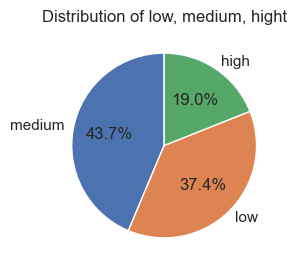

In [7]:
label_counts = white_red_df.quality_label.value_counts()
plt.figure(figsize= (3,3))
sns.set(style = 'whitegrid')
plt.pie(label_counts, labels = label_counts.index, autopct = '%1.1f%%', startangle = 90)
plt.title('Distribution of low, medium, hight')
plt.show()

In [8]:
'''lets encode the data'''
encoder = OneHotEncoder(handle_unknown= 'ignore', sparse_output= False).set_output(transform= 'pandas')

colour_encoded_data = encoder.fit_transform(white_red_copy[['wine_type']])
if 'wine_type' in white_red_copy.columns:
    ml_df = pd.concat([white_red_copy, colour_encoded_data], axis= 1)
#print(white_red_copy.columns)
#ml_df = white_red_copy[['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar','chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       #'pH', 'sulphates', 'alcohol', 'quality','wine_type_red']]
if 'wine_type' in ml_df.columns:
    ml_df.drop('wine_type', axis=1, inplace= True)
    ml_df.drop('wine_type_red', axis = 1, inplace = True)
    #ml_df.drop(['quality', 'quality_label', 'colour'], axis=1, inplace= True)
display (ml_df.head())


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,colour,quality_label,wine_type_white
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,white,medium,1.0
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,white,medium,1.0
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,white,medium,1.0
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,white,medium,1.0
6,6.2,0.32,0.16,7.0,0.045,30.0,136.0,0.9949,3.18,0.47,9.6,6,white,medium,1.0


In [9]:
categories = ['low', 'medium', 'high']
categories = np.reshape(categories, (1, -1))
categories

array([['low', 'medium', 'high']], dtype='<U6')

In [10]:
''' lets use label encoder to encode the wine_quality
we cannot use onehot encoder as that only does binary, dichotomous choices
low 1
medium 2
high 0
'''
# from sklearn.preprocessing import LabelEncoder

# from sklearn.preprocessing import OrdinalEncoder
# categories = ['low', 'medium', 'high']
# categories = np.reshape(categories, (1, -1))
# oe = OrdinalEncoder(categories = ['low', 'medium', 'high'])
# ml_df['quality_label_encoded'] = oe.fit_transform(ml_df['quality_label'])
# print(ml_df.head(20))
# display(ml_df.info())

quality_codes = {'low' : 0, 'medium': 1, 'high':2}

ml_df['quality_label'].replace(quality_codes, inplace= True)
ml_df['quality_label_encoded'] = ml_df.quality_label
print(ml_df.tail(20))



      fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  alcohol  quality colour  quality_label  wine_type_white  quality_label_encoded
1577            6.2             0.700         0.15             5.1      0.076                 13.0                  27.0  0.99622  3.54       0.60     11.9        6    red              1              0.0                      1
1578            6.8             0.670         0.15             1.8      0.118                 13.0                  20.0  0.99540  3.42       0.67     11.3        6    red              1              0.0                      1
1579            6.2             0.560         0.09             1.7      0.053                 24.0                  32.0  0.99402  3.54       0.60     11.3        5    red              0              0.0                      0
1580            7.4             0.350         0.33             2.4      0.068               

In [11]:
''' drop other unwanted columns: quality_label, colour, quality'''
for val in ['quality_label','colour', 'quality', 'wine_type']:
    if val in ml_df.columns:
        ml_df.drop(val, axis =1, inplace= True)
display(ml_df.head())
ml_df2 = ml_df.copy().reset_index()

ml_df2.to_csv('whole_csv.csv', index=False)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,wine_type_white,quality_label_encoded
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,1.0,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,1.0,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,1.0,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1.0,1
6,6.2,0.32,0.16,7.0,0.045,30.0,136.0,0.9949,3.18,0.47,9.6,1.0,1


In [12]:
''' split the data'''
X_train, x_test, Y_train, y_test = train_test_split( ml_df.iloc[:,:-1],ml_df.iloc[:, -1:], test_size = 0.2, random_state = 42)
# display(X_train.shape)
# display(x_test.shape)
# display(Y_train.shape)
# display(y_test.shape)
print(Y_train.head())
print(X_train.head())


      quality_label_encoded
3207                      1
612                       0
71                        0
3857                      1
312                       1
      fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  alcohol  wine_type_white
3207            6.8              0.21         0.42             1.2      0.045                 24.0                 126.0  0.99234  3.09       0.87     10.9              1.0
612             7.5              0.23         0.68            11.0      0.047                 37.0                 133.0  0.99780  2.99       0.38      8.8              1.0
71              6.8              0.30         0.23             4.6      0.061                 50.5                 238.5  0.99580  3.32       0.60      9.5              1.0
3857            5.4              0.17         0.27             2.7      0.049                 28.0                 104.0  0.99224  3.46     

In [13]:
def log_regress(X_train, Y_train, x_test, y_test, graph):
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import accuracy_score
    Y_train = np.ravel(Y_train)
    y_test = np.ravel(y_test)
    lr = LogisticRegression(random_state = 42, max_iter = 10000, multi_class= 'multinomial')
    lr.fit(X_train, Y_train)
    pred_lr = lr.predict(x_test)
    confu_mat = confusion_matrix(y_test, pred_lr)
    accuracy_percentage = round(accuracy_score(y_test, pred_lr) * 100,2)
    #print("Accuracy of Logistic Regression:", accuracy_percentage, "%")
    
#printing a graph of the heatmap
    if graph == True:
        sns.heatmap(confu_mat, annot=True, fmt= 'g', cmap = 'Blues')
        plt.suptitle('Logistic Regression Confusion Map')        
        plt.show()
    return accuracy_percentage
log_regress(X_train, Y_train, x_test, y_test, False)

60.81

In [14]:
'''neighbours classifier''' 
def neigh_class(X_train, Y_train, x_test, y_test, graph):
    Y_train = np.ravel(Y_train)
    y_test = np.ravel(y_test)
    from sklearn.neighbors import KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
    knn.fit(X_train, Y_train)
    accuracy_percentage = (knn.score(x_test, y_test) * 100).round(2)
    #print("Accuracy of Neighbours Classifier:", accuracy_percentage, "%")
    pred_neighbours = knn.predict(x_test)
    confu_mat = confusion_matrix(y_test, pred_neighbours)    
    if graph == True:
        sns.heatmap(confu_mat, annot=True, fmt= 'g', cmap = 'Blues')
        plt.suptitle('Random Forest Confusion Map')
        plt.show()
    #print('________________')
    return accuracy_percentage



In [15]:
'''decision tree'''
def dec_tree(X_train, Y_train, x_test, y_test, graph):
    
    Y_train = np.ravel(Y_train)
    y_test = np.ravel(y_test)
    from sklearn.tree import DecisionTreeClassifier
    tree = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
    tree.fit(X_train, Y_train)
    accuracy_percentage = (tree.score(x_test, y_test) * 100).round(2)
    #print("Accuracy of Decision Tree:", accuracy_percentage, "%")
    pred_tree = tree.predict(x_test)
    confu_mat = confusion_matrix(y_test, pred_tree)
    plt.show()
    if graph == True:
        sns.heatmap(confu_mat, annot=True, fmt= 'g', cmap = 'Blues')
        plt.suptitle('Decision Tree Confusion Map')
        plt.show()
    
    #print('________________')
    return accuracy_percentage

dec_tree(X_train, Y_train, x_test, y_test, False)



51.6

In [16]:
'''random forest'''
def ran_forest(X_train, Y_train, x_test, y_test, graph) :
    from sklearn.ensemble import RandomForestClassifier
    Y_train = np.ravel(Y_train)
    y_test = np.ravel(y_test)
    forest = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 10)
    forest.fit(X_train, Y_train)
    accuracy_percentage = (forest.score(x_test, y_test) * 100).round(2)
    pred_forest = forest.predict(x_test)
    confu_mat = confusion_matrix(y_test, pred_forest)
    
    #print("Accuracy of Random Forest:", accuracy_percentage, "%")    
    if graph == True:
        sns.heatmap(confu_mat, annot=True, fmt= 'g', cmap = 'Blues')
        plt.suptitle('Random Forest Confusion Map')
        plt.show()
    #print('________________')
    return accuracy_percentage



In [17]:
'''Linear regression'''
def lin_reg(X_train, Y_train, x_test, y_test):
    Y_train = np.ravel(Y_train)
    y_test = np.ravel(y_test)
    from sklearn import linear_model
    linreg = linear_model.LinearRegression()
    linreg.fit(X_train, Y_train)
    accuracy_percentage = (linreg.score(x_test, y_test) * 100).round(2)
    pred_linreg = linreg.predict(x_test)

    #print("Accuracy of Linear Regression:", accuracy_percentage, "%")
    #print('________________')
    return accuracy_percentage




In [18]:
#log_regress(X_train, Y_train, x_test, y_test, False)
#lin_reg(X_train, Y_train, x_test, y_test)
# neigh_class(X_train, Y_train, x_test, y_test, False),
# dec_tree(X_train, Y_train, x_test, y_test, False),
# ran_forest(X_train, Y_train, x_test, y_test, False)]

In [19]:
index_names = ['Logistic Regression', 'Linear Regression', 'Neighbours Classifier', 'Decision Tree', 'Random Forest']
comparison_df = pd.DataFrame(index=index_names)
#ml_df = ml_df.drop(['quality'], axis = 1)X_train, x_test, Y_train, y_test = train_test_split( ml_df.iloc[:,:-1],ml_df.iloc[:, -1:], test_size = 0.2, random_state = 42)

comparison_df['all_variables'] = [log_regress(X_train, Y_train, x_test, y_test, False),
lin_reg(X_train, Y_train, x_test, y_test),
neigh_class(X_train, Y_train, x_test, y_test, False),
dec_tree(X_train, Y_train, x_test, y_test, False),
ran_forest(X_train, Y_train, x_test, y_test, False)]
display(comparison_df)

,all_variables
Logistic Regression,60.81
Linear Regression,35.98
Neighbours Classifier,47.09
Decision Tree,51.60
Random Forest,58.36


In [20]:
''' create a correlation matrix between quality_label and the other variables
then save it as a sorted list where the names are in order
sorted list of 

'''
corr = ml_df.corr()

corr_list = corr['quality_label_encoded'][:-1]

corr_list = corr_list.apply(lambda x: abs(x))
corr_list = corr_list.sort_values()
corr_list_names = corr_list.index



In [21]:
'''create my DF showing the results of my algorithms. WE will start with all columsn'''
comparison_df = pd.DataFrame(index=index_names)
comparison_df['all'] = [log_regress(X_train, Y_train, x_test, y_test, False),
lin_reg(X_train, Y_train, x_test, y_test),
neigh_class(X_train, Y_train, x_test, y_test, False),
dec_tree(X_train, Y_train, x_test, y_test, False),
ran_forest(X_train, Y_train, x_test, y_test, False)]
display(comparison_df)



,all
Logistic Regression,60.81
Linear Regression,35.98
Neighbours Classifier,47.09
Decision Tree,51.60
Random Forest,58.36


In [22]:
print(ml_df.head())

   fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  alcohol  wine_type_white  quality_label_encoded
0            7.0              0.27         0.36            20.7      0.045                 45.0                 170.0   1.0010  3.00       0.45      8.8              1.0                      1
1            6.3              0.30         0.34             1.6      0.049                 14.0                 132.0   0.9940  3.30       0.49      9.5              1.0                      1
2            8.1              0.28         0.40             6.9      0.050                 30.0                  97.0   0.9951  3.26       0.44     10.1              1.0                      1
3            7.2              0.23         0.32             8.5      0.058                 47.0                 186.0   0.9956  3.19       0.40      9.9              1.0                      1
6            6.2              0.32 

In [23]:
''' using a for loop we will remove one column at a time based on the columns correlation with our target depenedent variable
using our corr_list_names variable '''
for val in corr_list_names[:-1]:
    ml_df = ml_df.drop([val], axis = 1)
    X_train, x_test, Y_train, y_test = train_test_split( ml_df.iloc[:,:-1],ml_df.iloc[:, -1:], test_size = 0.2, random_state = 42)
    comparison_df[val] = [log_regress(X_train, Y_train, x_test, y_test, False),
    lin_reg(X_train, Y_train, x_test, y_test),
    neigh_class(X_train, Y_train, x_test, y_test, False),
    dec_tree(X_train, Y_train, x_test, y_test, False),
    ran_forest(X_train, Y_train, x_test, y_test, False)]

#backwards elimination

In [24]:
'''adding a style to highlight teh highest value in each row'''

def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: lightyellow' if v else '' for v in is_max]


comparison_df = comparison_df.style.apply(highlight_max, axis = 1)

display(comparison_df)

,all,free_sulfur_dioxide,sulphates,pH,total_sulfur_dioxide,fixed_acidity,residual_sugar,citric_acid,wine_type_white,chlorides,volatile_acidity,density
Logistic Regression,60.810000,61.000000,60.710000,59.400000,59.210000,59.770000,59.120000,58.830000,58.930000,58.740000,54.610000,54.610000
Linear Regression,35.980000,35.550000,34.240000,33.670000,33.660000,33.720000,33.620000,33.630000,33.540000,33.530000,26.260000,26.360000
Neighbours Classifier,47.090000,49.250000,49.910000,49.810000,53.670000,52.630000,53.850000,53.760000,53.290000,51.320000,51.320000,49.910000
Decision Tree,51.600000,51.880000,51.220000,51.410000,51.410000,52.070000,50.000000,46.520000,47.270000,50.660000,48.210000,55.360000
Random Forest,58.360000,57.710000,58.550000,57.140000,56.770000,56.480000,57.330000,56.110000,54.610000,53.570000,49.530000,54.700000


In [25]:
#work out evaluation metrics
def compute_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division = 1)
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return accuracy, precision, recall, f1

In [26]:
'''Playing with K-folds: decision tree'''

def dec_tree_kfold(X, Y):
    Y = np.ravel(Y)
    #creating an instance of the decision Tree classifier
    tree = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
    #how many 'folds' do we want
    n_folds = 3
    #initialize the StratifiedKFold object
    skf = StratifiedKFold(n_splits= n_folds, shuffle = True, random_state=42)
    
    #used to hold results from each loop 
    accuracy_list, precision_list, recall_list, f1_list, kappa_list = [], [], [], [], []

    #because n_folds= 5 this should run 5 times
    #it will return two lists of indexes - 1 for the training: X and 1 for the test: Y
    for train, test in skf.split(X ,Y):
        #we isolate the appropriate indexes for our training and our testing
        X_train_k, X_test_k = X.loc[train], X.loc[test]
        y_train_k, y_test_k = Y[train], Y[test]
        #we enter our training data in to the instance of DecisionTreeClassifier we created
        tree.fit(X_train_k, y_train_k)
        #we test our model by entering our test X ie. the DF with our variables we have not used so far
        y_pred = tree.predict(X_test_k)
        #use the inbuilt compute_metrics to get the accuracy, precision, recall and f1 stats and add them to our container lists
        accuracy, precision, recall, f1 = compute_metrics(y_test_k, y_pred)
        accuracy_list.append(accuracy)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

        kappa_score = cohen_kappa_score(y_test_k, y_pred)
        kappa_list.append(kappa_score)



    #get the average of each our run throughs
    accuracy = np.mean(accuracy_list)
    precision = np.mean(accuracy_list)
    recall = np.mean(recall_list)
    f1 = np.mean(f1_list)
    kappa = np.mean(kappa_list)
    return [accuracy, precision, recall, f1, kappa]


In [27]:
def random_forest_kfold(X, Y):
    Y = np.ravel(Y)
    #creating an instance of the random forest classifier
    tree = RandomForestClassifier(criterion = 'entropy', random_state = 0)
    #how many 'folds' do we want
    n_folds = 3
    #initialize the StratifiedKFold object
    skf = StratifiedKFold(n_splits= n_folds, shuffle = True, random_state=42)
    
    #used to hold results from each loop 
    accuracy_list, precision_list, recall_list, f1_list, kappa_list = [], [], [], [], []

    #because n_folds= 5 this should run 5 times
    #it will return two lists of indexes - 1 for the training: X and 1 for the test: Y
    for train, test in skf.split(X ,Y):
        #we isolate the appropriate indexes for our training and our testing
        X_train_k, X_test_k = X.loc[train], X.loc[test]
        y_train_k, y_test_k = Y[train], Y[test]
        #we enter our training data in to the instance of DecisionTreeClassifier we created
        tree.fit(X_train_k, y_train_k)
        #we test our model by entering our test X ie. the DF with our variables we have not used so far
        y_pred = tree.predict(X_test_k)
        #use the inbuilt compute_metrics to get the accuracy, precision, recall and f1 stats and add them to our container lists
        accuracy, precision, recall, f1 = compute_metrics(y_test_k, y_pred)
        accuracy_list.append(accuracy)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
        kappa_score = cohen_kappa_score(y_test_k, y_pred)
        kappa_list.append(kappa_score)

    #get the average of each our run throughs
    accuracy = np.mean(accuracy_list)
    precision = np.mean(accuracy_list)
    recall = np.mean(recall_list)
    f1 = np.mean(f1_list)
    kappa = np.mean(kappa_list)
    return [accuracy, precision, recall, f1, kappa]


In [28]:
'''K-folds for K neighbours KNeighborsClassifier '''
def kneigh_class_k(X, Y):
    Y = np.ravel(Y)
    #creating an instance of the kneighbours classifier
    knc = KNeighborsClassifier()
    #how many 'folds' do we want
    n_folds = 3
    #initialize the StratifiedKFold object
    skf = StratifiedKFold(n_splits= n_folds, shuffle = True, random_state=42)
    
    #used to hold results from each loop 
    accuracy_list, precision_list, recall_list, f1_list, kappa_list = [], [], [], [], []

    #because n_folds= 5 this should run 5 times
    #it will return two lists of indexes - 1 for the training: X and 1 for the test: Y
    for train, test in skf.split(X ,Y):
        #we isolate the appropriate indexes for our training and our testing
        X_train_k, X_test_k = X.loc[train], X.loc[test]
        y_train_k, y_test_k = Y[train], Y[test]
        #we enter our training data in to the instance of DecisionTreeClassifier we created
        knc.fit(X_train_k, y_train_k)
        #we test our model by entering our test X ie. the DF with our variables we have not used so far
        y_pred = knc.predict(X_test_k)
        #use the inbuilt compute_metrics to get the accuracy, precision, recall and f1 stats and add them to our container lists
        accuracy, precision, recall, f1 = compute_metrics(y_test_k, y_pred)
        accuracy_list.append(accuracy)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
        kappa_score = cohen_kappa_score(y_test_k, y_pred)
        kappa_list.append(kappa_score)

    #get the average of each our run throughs
    accuracy = np.mean(accuracy_list)
    precision = np.mean(accuracy_list)
    recall = np.mean(recall_list)
    f1 = np.mean(f1_list)
    kappa = np.mean(kappa_list)
    return [accuracy, precision, recall, f1, kappa]





In [29]:
'''Logistic regression for Kfolds'''
#Where X is a DF with my dependent variables and Y is a series containing encoded values
def log_regress_k(X, Y):
    Y = np.ravel(Y)
    #creating an instance of the decision Tree classifier
    lr = LogisticRegression(random_state= 42, max_iter = 1000, multi_class = 'multinomial')
    #how many 'folds' do we want
    n_folds = 3
    #initialize the StratifiedKFold object
    skf = StratifiedKFold(n_splits= n_folds, shuffle = True, random_state=42)
    
    #used to hold results from each loop 
    accuracy_list, precision_list, recall_list, f1_list, kappa_list = [], [], [], [], []

    #because n_folds= 5 this for loop should run 3 times
    #it will return two lists of indexes - 1 for the training: X and 1 for the test: Y
    for train, test in skf.split(X ,Y):
        #we isolate the appropriate indexes for our training and our testing
        X_train_k, X_test_k = X.loc[train], X.loc[test]
        y_train_k, y_test_k = Y[train], Y[test]
        #we enter our training data in to the instance of DecisionTreeClassifier we created
        lr.fit(X_train_k, y_train_k)
        #we test our model by entering our test X ie. the DF with our variables we have not used so far
        y_pred = lr.predict(X_test_k)
        #use the inbuilt compute_metrics to get the accuracy, precision, recall and f1 stats and add them to our container lists
        accuracy, precision, recall, f1 = compute_metrics(y_test_k, y_pred)
        accuracy_list.append(accuracy)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
        kappa_score = cohen_kappa_score(y_test_k, y_pred)
        kappa_list.append(kappa_score)

    #get the average of each our run throughs
    accuracy = np.mean(accuracy_list)
    precision = np.mean(accuracy_list)
    recall = np.mean(recall_list)
    f1 = np.mean(f1_list)
    kappa = np.mean(kappa_list)
    return [accuracy, precision, recall, f1, kappa]



In [30]:
'''naive bayes with K-Folds'''

#Where X is a DF with my dependent variables and Y is a series containing encoded values
def gaussian_NB_k(X, Y):
    from sklearn.naive_bayes import GaussianNB
    Y = np.ravel(Y)
    #creating an instance of the decision Tree classifier
    gnb = GaussianNB()
    #how many 'folds' do we want
    n_folds = 3
    #initialize the StratifiedKFold object
    skf = StratifiedKFold(n_splits= n_folds, shuffle = True, random_state=42)
    
    #used to hold results from each loop 
    accuracy_list, precision_list, recall_list, f1_list, kappa_list = [], [], [], [], []

    #because n_folds= 5 this for loop should run 3 times
    #it will return two lists of indexes - 1 for the training: X and 1 for the test: Y
    for train, test in skf.split(X ,Y):
        #we isolate the appropriate indexes for our training and our testing
        X_train_k, X_test_k = X.loc[train], X.loc[test]
        y_train_k, y_test_k = Y[train], Y[test]
        #we enter our training data in to the instance of DecisionTreeClassifier we created
        gnb.fit(X_train_k, y_train_k)
        #we test our model by entering our test X ie. the DF with our variables we have not used so far
        y_pred = gnb.predict(X_test_k)
        #use the inbuilt compute_metrics to get the accuracy, precision, recall and f1 stats and add them to our container lists
        accuracy, precision, recall, f1 = compute_metrics(y_test_k, y_pred)
        accuracy_list.append(accuracy)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
        kappa_score = cohen_kappa_score(y_test_k, y_pred)
        kappa_list.append(kappa_score)

    #get the average of each our run throughs
    accuracy = np.mean(accuracy_list)
    precision = np.mean(accuracy_list)
    recall = np.mean(recall_list)
    f1 = np.mean(f1_list)
    kappa = np.mean(kappa_list)
    return [accuracy, precision, recall, f1, kappa]


In [31]:
'''support vector K with K-Folds'''

#Where X is a DF with my dependent variables and Y is a series containing encoded values
def support_vector_k(X, Y):
    from sklearn.svm import SVC
    Y = np.ravel(Y)
    #creating an instance of the decision Tree classifier
    svc = SVC()
    #how many 'folds' do we want
    n_folds = 3
    #initialize the StratifiedKFold object
    skf = StratifiedKFold(n_splits= n_folds, shuffle = True, random_state=42)
    
    #used to hold results from each loop 
    accuracy_list, precision_list, recall_list, f1_list, kappa_list = [], [], [], [], []

    #because n_folds= 5 this for loop should run 3 times
    #it will return two lists of indexes - 1 for the training: X and 1 for the test: Y
    for train, test in skf.split(X ,Y):
        #we isolate the appropriate indexes for our training and our testing
        X_train_k, X_test_k = X.loc[train], X.loc[test]
        y_train_k, y_test_k = Y[train], Y[test]
        #we enter our training data in to the instance of DecisionTreeClassifier we created
        svc.fit(X_train_k, y_train_k)
        #we test our model by entering our test X ie. the DF with our variables we have not used so far
        y_pred = svc.predict(X_test_k)
        #use the inbuilt compute_metrics to get the accuracy, precision, recall and f1 stats and add them to our container lists
        accuracy, precision, recall, f1 = compute_metrics(y_test_k, y_pred)
        accuracy_list.append(accuracy)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
        kappa_score = cohen_kappa_score(y_test_k, y_pred)
        kappa_list.append(kappa_score)

    #get the average of each our run throughs
    accuracy = np.mean(accuracy_list)
    precision = np.mean(accuracy_list)
    recall = np.mean(recall_list)
    f1 = np.mean(f1_list)
    kappa = np.mean(kappa_list)
    return [accuracy, precision, recall, f1, kappa]



In [32]:
comparison_df2 = pd.DataFrame(index=['accuracy', 'precision', 'recall', 'f1', 'kappa'])


In [33]:
#dec_tree_kfold(ml_df2.iloc[:,:-1], ml_df2.iloc[:, -1:])

comparison_df2['Decision_tree_K'] = dec_tree_kfold(ml_df2.iloc[:,:-1], ml_df2.iloc[:, -1:])


In [34]:
comparison_df2['Random_forest_K'] = random_forest_kfold(ml_df2.iloc[:,:-1], ml_df2.iloc[:, -1:])


In [35]:
comparison_df2['K-neighbours_K'] = kneigh_class_k(ml_df2.iloc[:,:-1], ml_df2.iloc[:, -1:])


In [36]:
comparison_df2['Logistic_regression_K'] = log_regress_k(ml_df2.iloc[:,:-1], ml_df2.iloc[:, -1:])


/Users/barry/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/barry/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

In [37]:
comparison_df2['gaussian_NB_k'] = gaussian_NB_k(ml_df2.iloc[:,:-1], ml_df2.iloc[:, -1:])


In [38]:
comparison_df2['support_vector_K'] = support_vector_k(ml_df2.iloc[:,:-1], ml_df2.iloc[:, -1:])


# Comparison of Evaluation metrics for algorithims
### Decision_tree_K, Random_forest_K, K-neighbours_K,Logistic_regression_K, gaussian_NB_k, support_vector_K

In [39]:
comparison_df3 = comparison_df2.style.apply(highlight_max, axis = 1)
display(comparison_df3)


,Decision_tree_K,Random_forest_K,K-neighbours_K,Logistic_regression_K,gaussian_NB_k,support_vector_K
accuracy,0.521428,0.624812,0.457143,0.530642,0.512217,0.443045
precision,0.521428,0.624812,0.457143,0.530642,0.512217,0.443045
recall,0.521428,0.624812,0.457143,0.530642,0.512217,0.443045
f1,0.521270,0.622509,0.445852,0.526147,0.513374,0.366791
kappa,0.245817,0.393599,0.115788,0.240154,0.238977,0.033558


# Comparison of algorithms
## removing features in consequtive increasing correlation score without returning removed features

In [40]:
display(comparison_df)

,all,free_sulfur_dioxide,sulphates,pH,total_sulfur_dioxide,fixed_acidity,residual_sugar,citric_acid,wine_type_white,chlorides,volatile_acidity,density
Logistic Regression,60.810000,61.000000,60.710000,59.400000,59.210000,59.770000,59.120000,58.830000,58.930000,58.740000,54.610000,54.610000
Linear Regression,35.980000,35.550000,34.240000,33.670000,33.660000,33.720000,33.620000,33.630000,33.540000,33.530000,26.260000,26.360000
Neighbours Classifier,47.090000,49.250000,49.910000,49.810000,53.670000,52.630000,53.850000,53.760000,53.290000,51.320000,51.320000,49.910000
Decision Tree,51.600000,51.880000,51.220000,51.410000,51.410000,52.070000,50.000000,46.520000,47.270000,50.660000,48.210000,55.360000
Random Forest,58.360000,57.710000,58.550000,57.140000,56.770000,56.480000,57.330000,56.110000,54.610000,53.570000,49.530000,54.700000
